In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay, ConvexHull
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.patches as patches
import os
import scipy.linalg as sclinalg
import copy

In [2]:
'''
Parameters
'''
radius = 1
res = 40
rho = 6.371e6
R = 1.496e11
alpha = 90/180*np.pi
beta = 30/180*np.pi

sigma = 0.001
nwater = 1.33
epsilon = 0.000000001

day = 24
Ndays = 365
year = Ndays*day
omega_day =  2*np.pi/day 
omega_year = 2*np.pi/year

delta_t = 1
delta_phi = np.pi/res
delta_theta = np.pi/res
delta_Omega = delta_phi*delta_theta 

hours = np.arange(0, day)
time_array = hours.copy()


for i in range(1, Ndays):
    time_array = np.append(time_array, hours + i*year/Ndays)

time_res = len(time_array)
print(time_res)

8760


In [3]:
'''
load in Transformation matrix and reflectivity maps

'''
print(alpha,beta)
filename1 = 'NEWTmatrices_res'+str(res)+'_tres'+str(time_res)+'_a'+str(alpha)+'_b'+str(beta)+'.npz'
loaded1 = np.load(filename1)
Tlambv = loaded1['lamb']
Tglintv = loaded1['glint']
Tseelv = loaded1['seel']

filename2 = 'V2Reflectivities_planet'+str(2)+'_res'+str(res)+'.npz'
loaded2  = np.load(filename2)

albedo_map = loaded2['lamb']
ocean_map = loaded2['glint']
seeliger_map = loaded2['seel']
albedo_pseudo = loaded2['pseudo']

albedo_pseudo_grid = albedo_pseudo.reshape((res,2*res), order = 'F')

1.5707963267948966 0.5235987755982988


In [4]:
'''
Compute light curves
'''

#f_curve_edge = np.matmul(T, albedo_map)*rho**2/(R**2)
#f_curve_face = np.matmul(T1, albedo_map)*rho**2/(R**2)

f_lamb_edge = np.matmul(Tlambv, albedo_map)*rho**2/(R**2)
f_glint_edge = 2*np.matmul(Tglintv, ocean_map)*rho**2/(R**2)
f_seel_edge  = 2*np.matmul(Tseelv, seeliger_map)*rho**2/(R**2)

f_lambglint = f_lamb_edge+f_glint_edge
f_total = f_lamb_edge+f_glint_edge+f_seel_edge

deviation = 0.1

N_ave = 200


noise_poisson = np.random.poisson(N_ave, time_res)/N_ave

noise_gauss = np.random.normal(1,deviation,time_res)

noise = noise_poisson


print(np.mean(noise))
#f_curve_edge_noisy = f_curve_edge  + noise_gauss*max(f_curve_edge)/100
#f_curve_face_noisy = f_curve_face + noise_gauss*max(f_curve_face)/100

f_lamb_noisy  = np.multiply(f_lamb_edge, noise)
f_glint_noisy = np.multiply(f_glint_edge, noise)
f_seel_noisy = np.multiply(f_seel_edge, noise)
f_total_noisy = np.multiply(f_total, noise)

0.9996894977168951


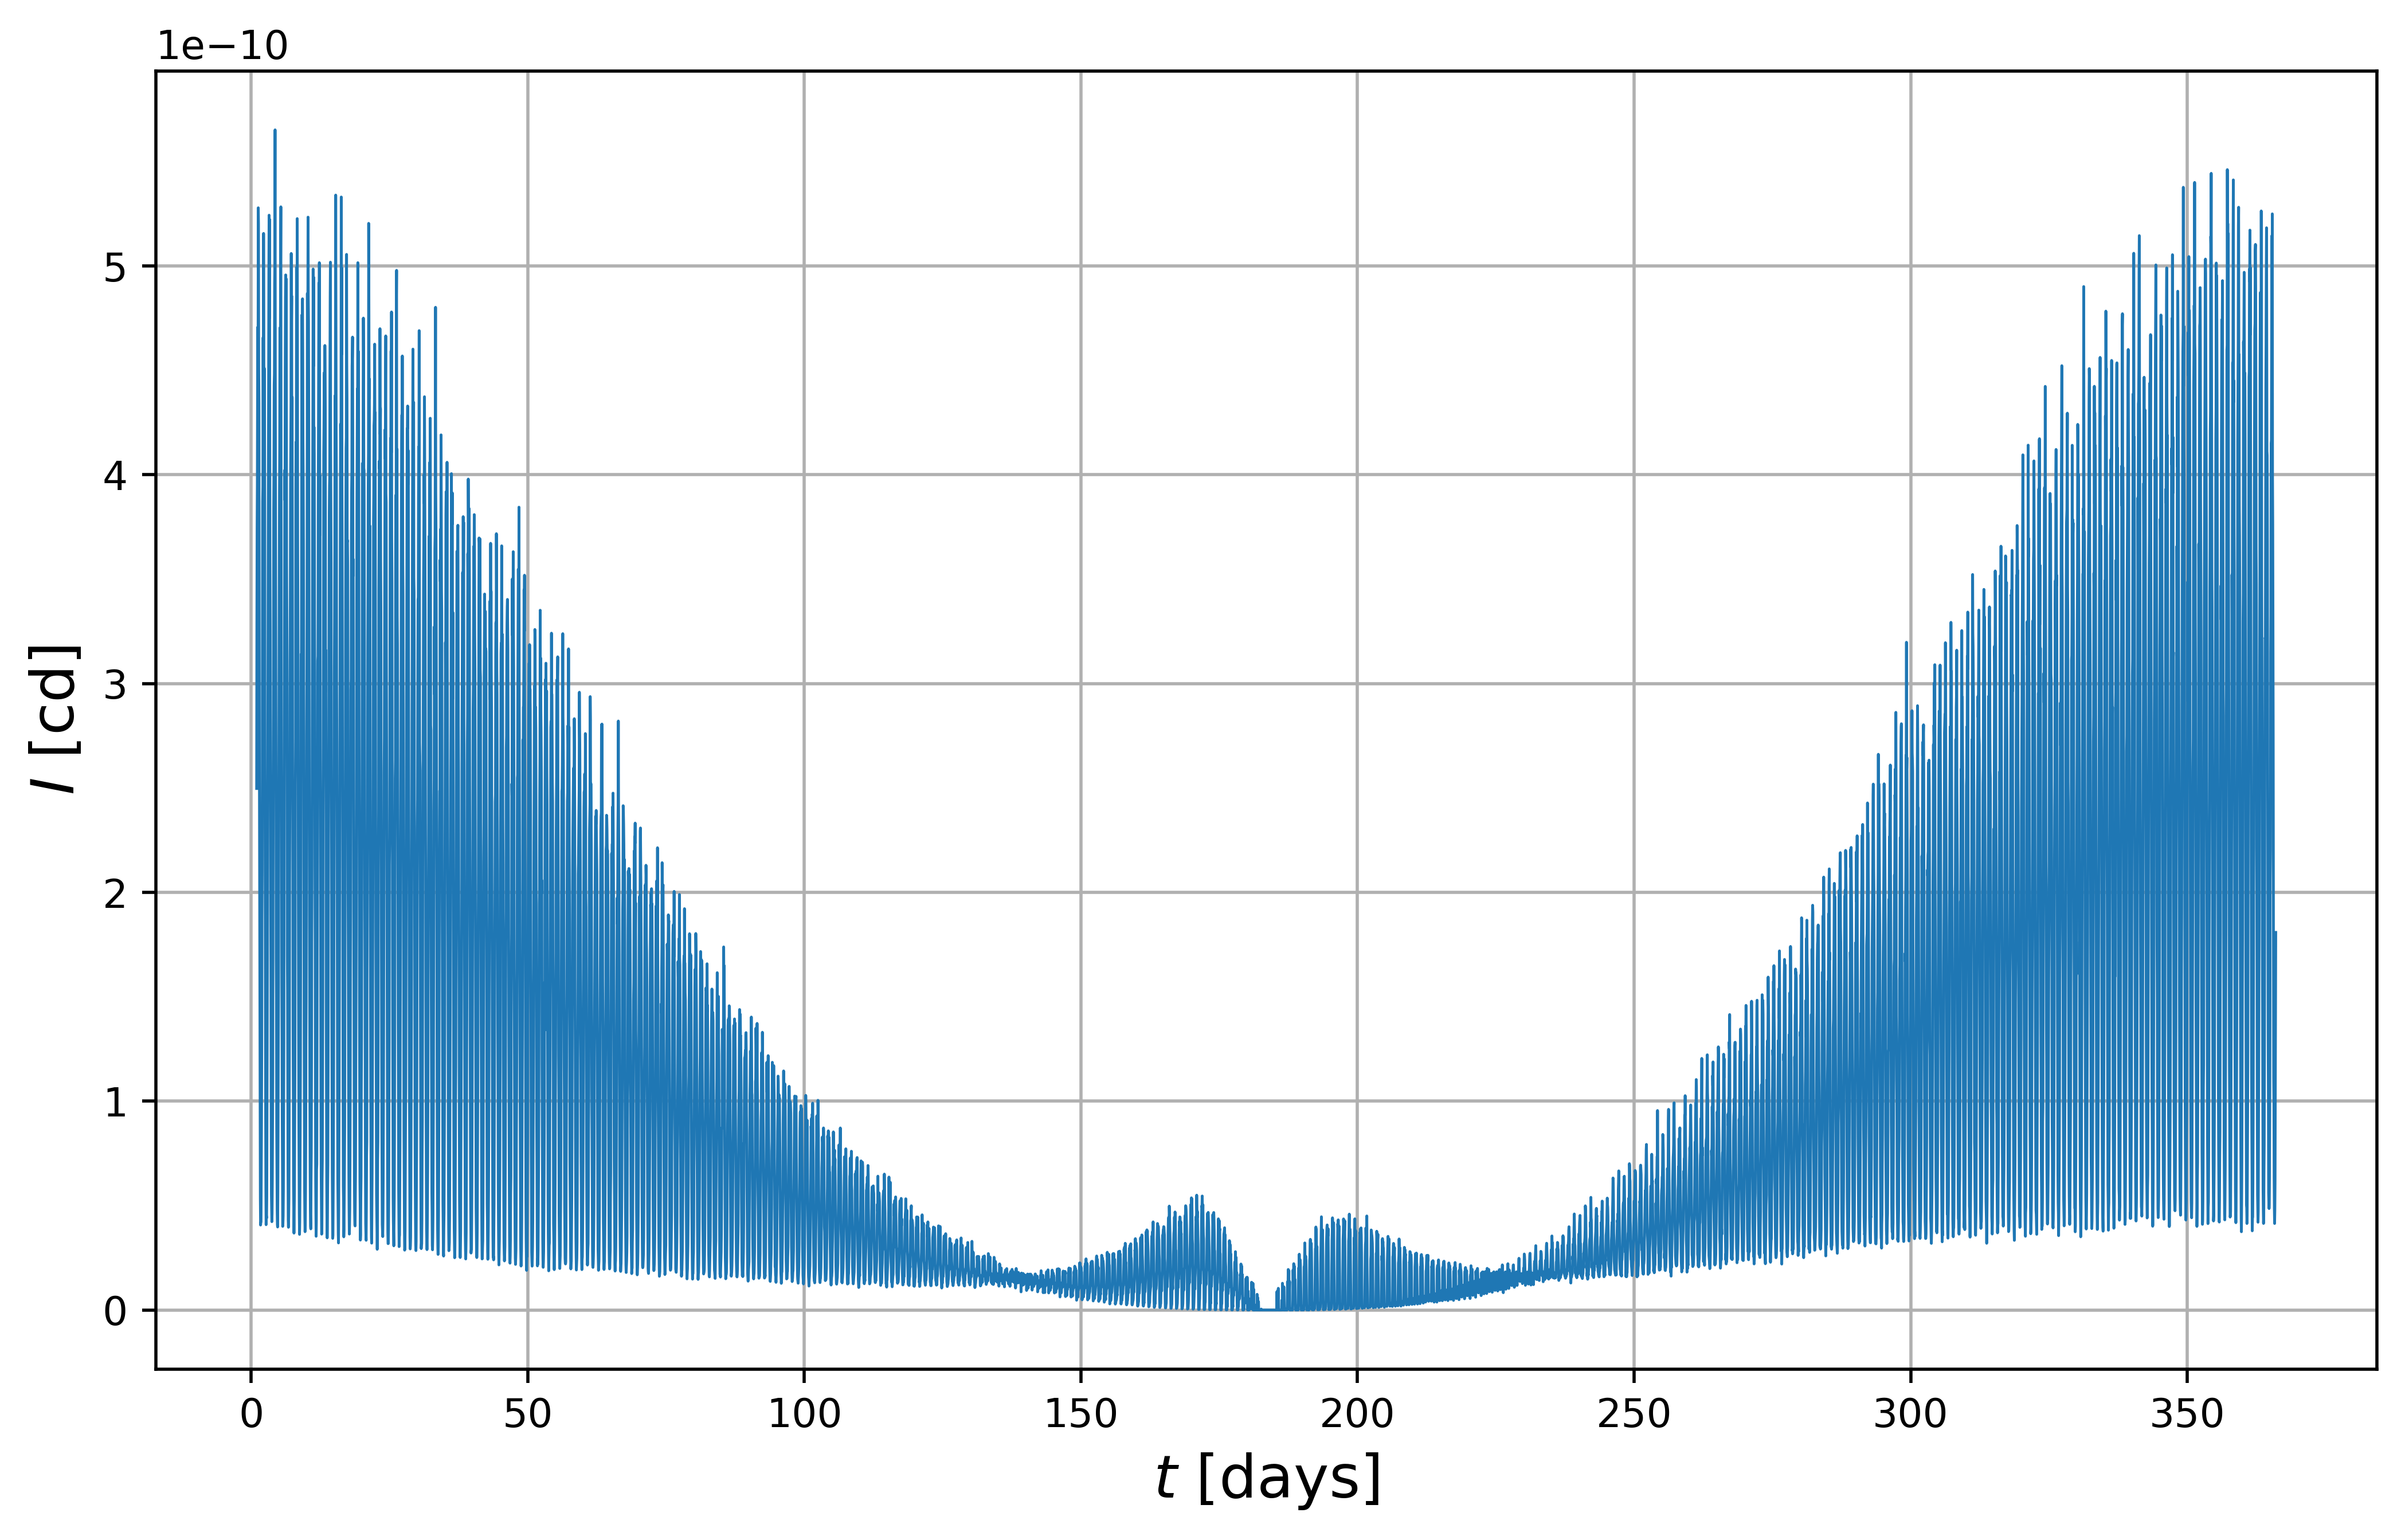

In [5]:
%matplotlib inline
f,ax=plt.subplots(figsize=(10,6), dpi=500)

daysaxis = np.linspace(1,365+1, num = len(time_array))

#ax.plot(daysaxis,f_lamb_edge, '-',label= 'Lambertian', alpha = 0.5)
#ax.plot(time_array,f_metal_edge, '-',label= '')
#ax.plot(daysaxis,f_glint_edge, '-',label= 'Fresnel', alpha = 0.5)
#ax.plot(daysaxis,f_seel_edge, '-',label= 'Lommel-Seeliger', alpha = 0.5)
ax.plot(daysaxis,f_total_noisy, '-', linewidth = 0.7, label= 'Composite', alpha = 1)

plt.xlabel(r'$t$ [days]',fontsize = 15)
plt.ylabel(r'$I$ [cd]',fontsize = 15)
#plt.title('')
#plt.legend()
plt.grid()
plt.show()

In [6]:
#Lambertian

Tcomp = np.concatenate((Tlambv,Tglintv,Tseelv),axis = 1)
SVCR = 0.02
Tcomp_pinv_edge = np.linalg.pinv(Tcomp, rcond = SVCR)



SVCR 0.02 Poisson 200


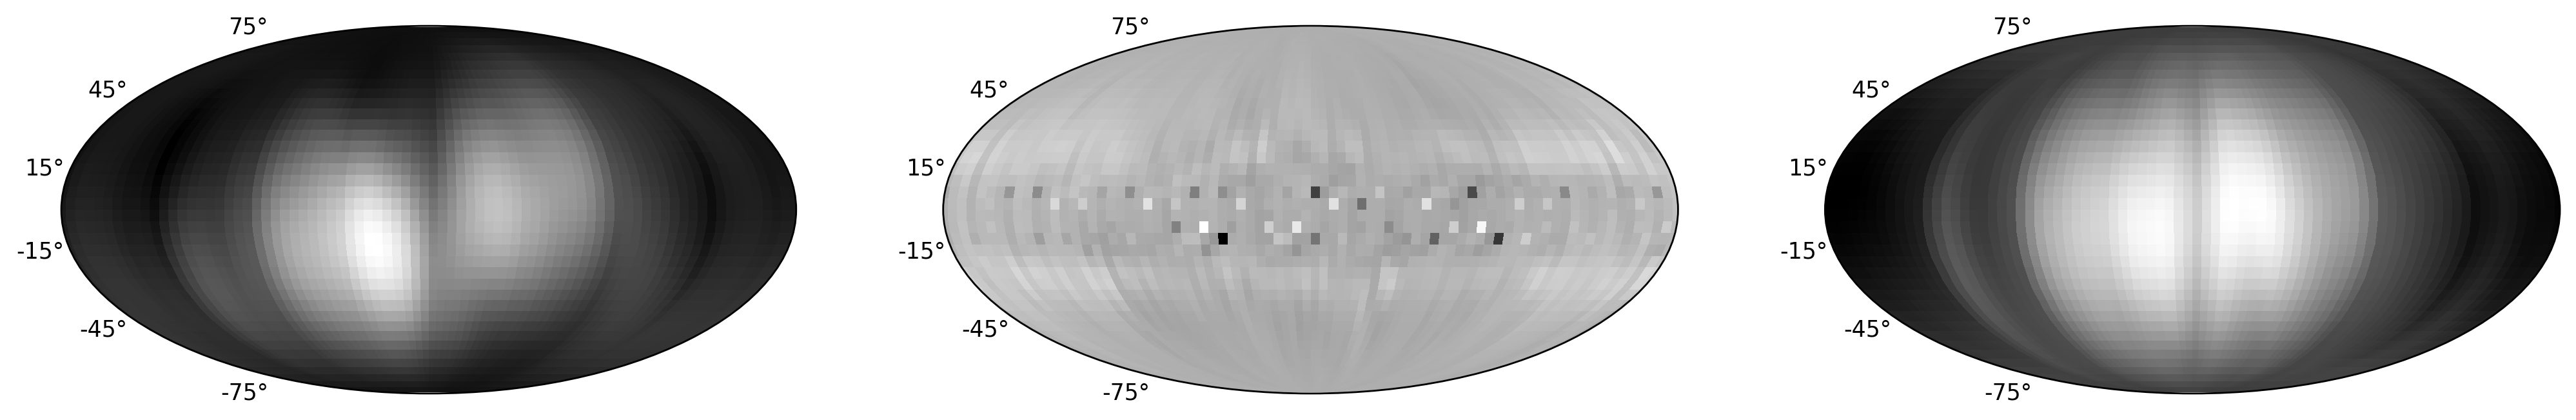

In [7]:
print('SVCR', SVCR, 'Poisson', N_ave)


Acomp_edge = np.matmul(Tcomp_pinv_edge, f_total_noisy)
A_lamb = Acomp_edge[:2*res*res]
A_glint = Acomp_edge[2*res*res:2*2*res*res]
A_seel = Acomp_edge[2*2*res*res:]

lamb_factor = 0.8*0.9/(max(A_lamb)-min(A_lamb))
seel_factor = 0.5*0.4/(max(A_seel)-min(A_seel))
glint_factor = 0.1/(max(A_glint)-min(A_glint))

A_lamb_scaled = (A_lamb-min(A_lamb))*lamb_factor
A_glint_scaled = (A_glint-min(A_glint))*glint_factor
A_seel_scaled = (A_seel-min(A_seel))*seel_factor


reconstruct_A_lamb_scaled = A_lamb_scaled.reshape((res,2*res),order = 'F')
reconstruct_A_glint_scaled = A_glint_scaled.reshape((res,2*res),order = 'F')
reconstruct_A_seel_scaled = A_seel_scaled.reshape((res,2*res),order = 'F')


albedo_map_grid = reconstruct_A_lamb_scaled
ocean_map_grid = reconstruct_A_glint_scaled
seeliger_map_grid = reconstruct_A_seel_scaled

#plot albedo specular and seeliger maps together


shrink = 0.9

newgistearth = cm.get_cmap('gist_earth', 4096)
newcolors = np.vstack((newgistearth(np.linspace(0,0.35,256)), newgistearth(np.linspace(0.45,1,256))))
newcmp = ListedColormap(newcolors)

albedo_colors = np.vstack((newgistearth(np.linspace(0.15,0.22,100)), newgistearth(np.linspace(0.45,0.55,200)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,200)), newgistearth(np.linspace(0.95,1,400))))
albedo_cmp = ListedColormap(albedo_colors)
albedo_colors1 = np.vstack((newgistearth(np.linspace(0.15,0.22,140)), newgistearth(np.linspace(0.45,0.55,180)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,280)), newgistearth(np.linspace(0.95,1,400))))
albedo_cmp1 = ListedColormap(albedo_colors1)

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,4), dpi = 250)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('')
ax2.title.set_text('')
ax3.title.set_text('')


im1 = ax1.pcolormesh(Lon,Lat, np.flipud(albedo_map_grid),cmap = 'gray')
#plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(ocean_map_grid),cmap = 'gray')
#plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')

     
im3 = ax3.pcolormesh(Lon,Lat, np.flipud(seeliger_map_grid),cmap = 'gray')
#plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')
                   
                                         
             
plt.show()


In [8]:
# f_test = np.matmul(Tlambv,A_lamb)
# %matplotlib widget
# f,ax=plt.subplots(figsize=(5,3), dpi=150)

# #ax.plot(time_array,f_curve_edge, '-',label= 'Edge-on old')

# #ax.plot(time_array,f_lamb_edge, '-',label= 'Edge-on Lambertian', alpha = 0.5)
# # #ax.plot(time_array,f_metal_edge, '-',label= 'Edge-on metal glint')
# # ax.plot(time_array,f_glint_edge, '-',label= 'Edge-on ocean glint', alpha = 0.5)
# # ax.plot(time_array,f_seel_edge, '-',label= 'Edge-on Seeliger', alpha = 0.5)


# ax.plot(time_array,f_lamb_noisy, '-',label= 'noisy lambertian', alpha = 0.5)
# ax.plot(time_array,f_test, '-',label= 'retrieved', alpha = .5)


# plt.xlabel('time')
# plt.ylabel('light curve')
# plt.title('Time signal')
# plt.legend()
# plt.grid()
# plt.show()